<a href="https://colab.research.google.com/github/HwangHanJae/Recommentaion_Study/blob/main/book_Recommender_Systems/Nearest_Neighbor_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이웃 기반 협업 필터링(메모리 기반 알고리즘)

- 협업필터링의 가장 초기 알고리즘

**유사한 사용자들은 평점을 주는 방식에서 유사한 패턴을 보이고 유사한 아이템에는 유사한 평점을 주는 사실을 기반으로 함**





## 사용자 기반 협업 필터링

사용자A 에게 추천을 하기 위하여 사용자A와 유사한 사용자들의 평점을 이용
- 예측된 사용자A의 평점은 피어그룹의 각 아이템의 평점에 대한 가중 평균으로 산정
  - 가중평균 : 산술평균을 계산할 때 자료 값의 중요도나 영향에 따라 가중치를 반영하여 구한 평균값( 출처 : [위키백과](https://ko.wikipedia.org/wiki/%EA%B0%80%EC%A4%91_%EC%82%B0%EC%88%A0_%ED%8F%89%EA%B7%A0]))

### 사용자 기반 이웃 모델
- 평점 예측이 계산되는 타깃 유저와 유사한 사용자를 찾기 위하여 정의
- 타깃 유저 i의 이웃을 찾기 위하여 모든 사용자와의 유사도를 계산
  - 유사도 계산은 사용자들마다 평점을 내리는 방식이 다를 수 있기 때문에 까다로움.
    - 사용자1은 대부분의 상품을 좋아하는 성향이라 평점을 높게 매길 수 있음
    - 사용자2는 대부분의 상품을 싫어하는 성향이라 평점을 낮게 매길 수 있음
    - 서로 다른 사용자들은 같은 상품에 대해서만 평가하지 않음

위의 문제를 해결하기 위하여 아래의 매커니즘을 확인해야 합니다.


In [ ]:
# 라이브러리
import pandas as pd
import numpy as np
import scipy.stats as stats

아래는 $m$ 사용자 $n$ 상품의 $m\times{n}$ 평점 행렬($R=[r_{uj}]$)를 정의한것입니다.

In [ ]:
#예제 테이블(R) 정의

values = [[7,6,7,4,5,4],
         [6,7,None,4,3,4],
         [None, 3,3,1,1,None],
         [1,2,2,3,3,4],
         [1,None,1,2,3,3]]

R = pd.DataFrame(values, columns = [1,2,3,4,5,6], index = [1,2,3,4,5])

R

,1,2,3,4,5,6
1,7.0,6.0,7.0,4,5,4.0
2,6.0,7.0,NaN,4,3,4.0
3,NaN,3.0,3.0,1,1,NaN
4,1.0,2.0,2.0,3,3,4.0
5,1.0,NaN,1.0,2,3,3.0


*$I_u$는 평점행렬($R$)에서 사용자($u$)에 의해 지정된 상품 색인 세트를 말합니다.*

예를 들어 위의 테이블 R에서  
2번 사용자는 첫 번째(1), 두 번째(2), 네 번째(4), 다섯 번째(5), 여섯 번째(6) 아이템에 평점이 매겨져있고, 세 번째(3) 아이템에는 평점이 매겨져있지 않고 결측값(NaN)으로 표현되어 있을 때  
$I_2 = \{1,2,4,5,6\}$ 라 표현합니다.

사용자(u), 사용자3(v) 모두가 평점을 매긴 아이템 집합은    
$I_{u}\cap{I_{v}}$라 표현합니다.

In [ ]:
# 사용자(u)가 평가한 아이템 집합을 반환하는 함수
# 평가하지 않았다면 None이기 때문에 인덱스를 반환하지 않음
def get_I_u(matrix, u):
  not_null_index = matrix.loc[u, matrix.loc[u].notnull()].index
  return set(not_null_index)

#I_2 2번 사용자가 평가한 아이템 집합
get_I_u(R, 2)

{1, 2, 4, 5, 6}

현실에서의 평점행렬(R)은 희소행렬의 형태로 평점을 매기지 않은 결측값(NaN)이 많이 분포되어 있을 것입니다.

따라서 $I_{u}\cap{I_{v}}$는 공집합일수 있고 공집합인 경우도 많습니다.

두 사용자(u, v)의 유사도를 알아내는 방법은 아래와 같이 [피어슨 상관계수](https://ko.wikipedia.org/wiki/%ED%94%BC%EC%96%B4%EC%8A%A8_%EC%83%81%EA%B4%80_%EA%B3%84%EC%88%98)를 이용하는 방법입니다.
- 피어슨 상관계수 -1 ~ 1의 사이의 값을 가짐
  - +1은 완벽한 양의 선형 상관 관계
  - -1은 완벽한 음의 선형 상관 관계
  - 0은 선형 상관 관계 없음
- 여기서는 1과 가까울수록 유사하다고 판단


In [ ]:
#함수를 직접 만들어 유사도 계산

#유저의 평균 계산
def get_M_u(matrix, u):
  
  # I_u = get_I_u(user_id)
  # I_u_norm = len(I_u)

  # ruk = table.loc[user_id].sum()

  # M_u = ruk / I_u_norm
  M_u = matrix.loc[u].mean()
  return M_u


# 피어슨 상관계수
# 공분산 / 표준편차(u) * 표준편차(v)
def Pearson(matrix, u, v):

  I_u = get_I_u(matrix, u)
  I_v = get_I_u(matrix, v)
  k = I_u.intersection(I_v)
  M_u = get_M_u(matrix, u)
  M_v = get_M_u(matrix, v)

  u_std = np.sqrt(np.sum(np.power((matrix.loc[u, k] - M_u), 2)))
  v_std = np.sqrt(np.sum(np.power((matrix.loc[v, k] - M_v),2)))

  co = np.sum((matrix.loc[u, k] - M_u) * (matrix.loc[v, k] - M_v))
  return co / (u_std * v_std)

In [ ]:
#1번, 3번 사용자의 유사도
Pearson(R, 1, 3)

0.8944271909999159

In [ ]:
#1번, 3번 사용자의 유사도
#pandas의 corr()함수를 이용하여 유사도를 계산
pearson = R.T.corr(method='pearson')
pearson.loc[1,3]

0.8944271909999159

피어슨 계수는 타깃 사용자와 다른 모든 사용자 간의 계산입니다.  
타깃 사용자의 피어 그룹을 정의하는 한 가지 방법으로는 타깃과 피어슨 계수가 가장 높은 k사용자 집합을 이용하는 것입니다.
- 이때 k는 Pearson()함수에서 사용된 k와 다름

위에서 언급한 것 처럼 사용자들은 평점을 내리는 방식이 다를 수 있습니다.
- 책에서는 평점에 각기 다른 스케일을 부여한다고 나와있음

평점 그 자체는 피어 그룹의 평균 평점을 결정하기 전에 행에 대해서 평균을 중심으로 재배열되어야 합니다.  

사용자 $u$의 아이템 $j$에 대한 평균 중심 평점 $s_{uj}$은 초기 평점 $r_{uj}$에서 사용자의 평균 평점을 빼는 것으로 정의할 수 있습니다.

$$s_{uj}=r_{uj}-μ_{u}$$


타깃 사용자 $u$의 상위-$k$ 피어 그룹에서의 아이템에 대한 평균 평점의 가중 평균은 평균 중심 예측에 활용됩니다.

이 예측 뒤에는 타깃 사용자의 평균 평점이 더해져 타깃 사용자 $u$의 아이템 $j$에 대한 평점 $\hat{r}_{uj}$예측이 이루어집니다.


$$\hat{r}_{uj} = μ_{u}+\frac{∑_{v\in{P_{u}(j)}}^{}Sim(u, v)⋅s_{vj}}{∑_{v\in{P_{u}(j)}}^{}|Sim(u, v)|}$$

$$= μ_{u}+\frac{∑_{v\in{P_{u}(j)}}^{}Sim(u, v)⋅(r_{vj}-μ_{v})}{∑_{v\in{P_{u}(j)}}^{}|Sim(u, v)|}$$

$P(j)$는 아이템 $j$에 대해 평점을 매긴 타깃 사용자 $u$의 가장 유사한 사용자 $k$명의 집합 1이라 생각해보면 타깃 사용자 $u$와 매우 낮은 혹은 음의 상관을 보이는 사용자는 제외시키기도 합니다.

$P(j)$를 어떻게 설정하느냐에 따라 예측된 평점이 달라집니다

### 사용자 기반 알고리즘 예시

테이블 R을 기반으로 3번 사용자의 가장 상위 아이템을 예측하기 위하여  
3번 사용자의 NaN값인 1번, 6번 아이템을 예측해야 합니다.

In [ ]:
R

,1,2,3,4,5,6
1,7.0,6.0,7.0,4,5,4.0
2,6.0,7.0,NaN,4,3,4.0
3,NaN,3.0,3.0,1,1,NaN
4,1.0,2.0,2.0,3,3,4.0
5,1.0,NaN,1.0,2,3,3.0


In [ ]:
#예측해야할 아이템을 찾는 함수
def find_predict_item_index(table, user_id):
  index = table.loc[user_id, table.loc[user_id].isna()].index
  return set(index)

In [ ]:
find_predict_item_index(R, 3)

{1, 6}

예측해야하는 item의 index를 찾았다면 $P(j)$ 피어그룹을 찾아야합니다.

피어그룹을 찾기 위하여 유사도를 계산해야 합니다.

여기서는 유사도를 구할때 피어슨 상관계수로 구합니다.  
- 코사인 유사도를 사용할 수도 있음

피어슨 상관계수를 사용할 경우 음의 상관계수와 상관이 없는 0의 값을 가진 데이터는 제외하도록 설정할 수 있습니다.

In [ ]:
#피어슨 상관계수를 기반으로 피어그룹을 찾는 함수
#j는 피어그룹의 크기,
def find_peer_group(table, user_id, j):
  #피어슨 상관계수 구하기
  pearson = table.T.corr(method='pearson')
  pearson = pearson.loc[user_id]
  # 조건 : 상관계수가 0보다 크고 자기자신이 아닌 데이터
  condition = (pearson > 0) & (pearson.index != user_id)
  peer_group  = pearson[condition].index[:j]

  return set(peer_group)

In [ ]:
find_peer_group(R,3)

{1, 2}

#### 평점 예측하기(basic)

$$\hat{r_{uj}} = \frac{∑_{k∈peer\_group}^{}(r_{kj}  * Pearson(u,k))}{∑_{k\in{peer\_group}}^{}Pearson(u,k)}$$

In [ ]:
def predict_r(table, user_id, item_id, j=5):
  #예측해야하는 아이템의 id를 찾음
  #item_idx = find_predict_item_index(table, user_id)

  #피어그룹 찾기
  peer_group = find_peer_group(table, user_id, j)

  #관측값(실제값)
  r = table.loc[peer_group, item_id].values

  #피어슨 상관계수 계산
  #Pearson(R, user_id, item_id)
  pearson = table.T.corr(method='pearson')
  #분모
  denominator = np.sum(pearson.loc[user_id, peer_group])
  #분자
  numerator = np.sum((r * pearson.loc[user_id, peer_group]))
  r_hat = (numerator / denominator)
  return r_hat

In [ ]:
predict_r(R, 3, 1)

6.479546404117822

In [ ]:
predict_r(R, 3, 6)

4.0

In [ ]:
temp1 = R.copy()

temp1.loc[3, 1] = 6.47
temp1.loc[3, 6] = 4

temp1

,1,2,3,4,5,6
1,7.00,6.0,7.0,4,5,4.0
2,6.00,7.0,NaN,4,3,4.0
3,6.47,3.0,3.0,1,1,4.0
4,1.00,2.0,2.0,3,3,4.0
5,1.00,NaN,1.0,2,3,3.0


사용자들은 평점을 내리는 방식이 사용자마다 다르기 때문에 1번,2번 사용자(피어 그룹)는 3번 사용자(타깃)에 비하여 더 긍정적인 평가를 하였습니다.

평균 중심 평점을 기반으로 계산하여 차이를 확인하겠습니다.


#### 평점 예측하기(평균 중심 계산)

$$\hat{r}_{uj} = μ_{u}+\frac{∑_{v\in{P_{u}(j)}}^{}Sim(u, v)⋅s_{vj}}{∑_{v\in{P_{u}(j)}}^{}|Sim(u, v)|}$$

$$= μ_{u}+\frac{∑_{v\in{P_{u}(j)}}^{}Sim(u, v)⋅(r_{vj}-μ_{v})}{∑_{v\in{P_{u}(j)}}^{}|Sim(u, v)|}$$

In [ ]:
def get_s(table):
  M_u = R.mean(axis=1)
  S = (R.T - M_u).T
  return S, M_u

In [ ]:
def predict_r_adv(table, user_id, item_id, j=5):
  #S 테이블 계산
  table_S, M_u = get_s(table)

  #피어그룹 찾기
  peer_group = find_peer_group(table, user_id, j)

  #관측값(실제값)
  s = table_S.loc[peer_group, item_id].values


  #피어슨 상관계수 계산
  pearson = table.T.corr(method='pearson')
  #분모
  denominator = np.sum(pearson.loc[user_id, peer_group])
  #분자
  numerator = np.sum((s * pearson.loc[user_id, peer_group]))
  #r_hat = (numerator / denominator) + M_u
  r_hat = (numerator / denominator) + M_u.loc[user_id]
  return r_hat

In [ ]:
predict_r_adv(R, 3, 1)

3.3438639212353465

In [ ]:
predict_r_adv(R, 3, 6)

0.864317517117525

In [ ]:
temp2 = R.copy()

temp2.loc[3, 1] = 3.34
temp2.loc[3, 6] = 0.86

temp2

,1,2,3,4,5,6
1,7.00,6.0,7.0,4,5,4.00
2,6.00,7.0,NaN,4,3,4.00
3,3.34,3.0,3.0,1,1,0.86
4,1.00,2.0,2.0,3,3,4.00
5,1.00,NaN,1.0,2,3,3.00


### 평점 예측하기 종합

- 6.47 --> 3.34
- 4 --> 0.86

값의 변화가 있는 것을 확인해볼 수 있습니다.

전의 예측 보다는 **조금 더 사용자의 평점을 내리는 방식에 맞게 변경된 것을 확인할 수 있습니다.**

이전 예측과 차이점을 확인해보면 3번 사용자에 대해서 아이템 1이 아이템 3(예측하지 않은 값)보다 추천 항목으로 우선순위가 더 높다는 것을 알려주기도 합니다.

하지만 아이템 6에 대하여 예측값은 큰 차이를 보입니다.
- 4 --> 0.86

3번 사용자는 가장 낮은 평점으로 4점으로 매겼지만 여기서의 예측값은 0.86으로 아주 낮은 값을 보여줍니다. 

피어그룹(1번, 2번 사용자)이 아이템 6에 대하여 다른 아이템 비하여 낮은 점수를 부여했기 때문에 위와 같은 결과가 나온 것입니다.

따라서 평균 중심 계산, 과정? 은 이미 평가된 평점에 대해 상대적으로 훨씬 좋은 예측합니다.

하지만 0.86은 1~7점 사이의 값을 벗어나기 때문에 벗어난 값에는 알맞은 값으로 대체해야 합니다.


### 유사도 함수 변형

실제로 유사도 함수를 변형에서 사용하는 경우가 있습니다.

피어그룹을 결정하는 과정에서 평점 그 자체에 유사도 함수를 사용하기도 합니다.


$$RawCosine(u, v) = \frac{∑_{k\in{I_{u}\cap{I_{v}}}}r_{uk}⋅r_{vk}}{\sqrt{∑_{k∈I_{u}∩I_{v}}r_{uk}^{2}}⋅\sqrt{∑_{k∈I_{u}∩I_{v}}r_{vk}^{2}}}$$


*RawCosine의 일부 구현에서 분모의 정규화는 상호 관련이 있는 아이템에 대해서만이 아닌 지정된 전체 아이템을 기반으로 합니다.*

$$RawCosine(u, v) = \frac{∑_{k∈I_{u}∩I_{v}}r_{uk}⋅r_{vk}}{\sqrt{∑_{k∈I_u}r_{uk}^{2}}⋅\sqrt{∑_{k∈I_v}r_{vk}^{2}}}$$

보편적으로 피어슨 상관계수는 평균 중심에서는 바이어스 조정 효과가 있기 때문에 RawCosine이 더 바람직합니다.

서로 다른 사용자가 전체 평점 부여하는 패턴에 있어서 서로 다르다는 것을 의미합니다.

- 중요도 가중치(significance weighting) : 두 명의 사용자가 공통적으로 평점을 부여한 수가 적다면, 유사도 함수는 두 사용자 쌍의 중요도를 덜 강조하기 위하애 할인 요인을 적용해 낮춤



$$DiscountedSim(u, v)=Sim(u, v)⋅\frac{min\{|I_{u}∩I_{v}|, β\}}{β}$$

할인 요인은 두 사용자 간의 공통으로 부여한 평점 개수가 특정 임계점 β보다 작은 경우 사용을 합니다.

- 할인 요인 값은 $\frac{min\{|I_{u}∩I_{v}|, β\}}{β}$와 같습니다.
- 할인 요인의 범위는 [0, 1] 안에서 움직입니다.

### 예측함수의 변형

평점 예측하기 에서 사용한 예측함수에는 다양한 변형이 있습니다.

위에서는 중심 $s_{uj}$를 기준으로 한 평점 $r_{uj}$의 평균 중심을 이용하였는데

대신에 $s_{uj}$를 사용자($u$)의 관측된 평점에 대한 표준편차($σ_{u}$)로 나누어주는 Z-스코어($z_{uj}$)를 사용할수 있습니다.

Z-스코어($z_{uj}$)를 구할 때 사용하는 표준편차(σ_{u})를 구하는 식은 아래와 같습니다.

$$σ_{u}=\sqrt{\frac{∑_{j∈I_{u}}(r_{uj}-μ_{u})^{2}}{|I_{u}|-1}}$$

Z-스코어($z_{uj}$)를 계산하는 식은 다음과 같습니다.

$$z_{uj}=\frac{r_{uj}-μ_{u}}{σ_{u}}=\frac{s_{uj}}{σ_{u}}$$

$P_{u}(j)$를 타깃 사용자($u$)의 상위-%k%명의 아이템의 평점을 기록한 피어 그룹(유사 사용자 집합)이라고 할때  
타깃 사용자($u$)의 아이템($j$)의 예측 평점을 ($\hat{r_{uj}}$)이라고 합니다.



예측 평점($\hat{r_{uj}}$)를 계산하는 식은 다음과 같습니다.

$$\hat{r}_{uj} = μ_{u}+σ_{u}\frac{∑_{v\in{P_{u}(j)}}^{}Sim(u, v)⋅z_{vj}}{∑_{v\in{P_{u}(j)}}^{}|Sim(u, v)|}$$

Z-스코어를 사용한 예측 방법은 예측 평점이 실제 평점 범위 밖에 있을 수 있습니다.

그럼에도 특정 사용자에 대한 항목의 순위를 매기는데 사용하고 있습니다.

타깃 사용자($u$)에 대한 사용자($v$)의 유사도 함수 $Sim(u, v)$에 따라 가중치가 계산이 되는데 
$Sim(u,v)$는 피어슨 상관계수에 의하여 계산되지만 α의 지수로 지수화해서 증폭시키는 방법이 있습니다.

$$Sim(u,v)=Pearson(u, v)^{α}, α>1$$

위의 식을 확인해보면

가중치 계산에서 유사도 중요성을 더 증폭시키는 방법이 가능합니다.



### 롱테일 문제

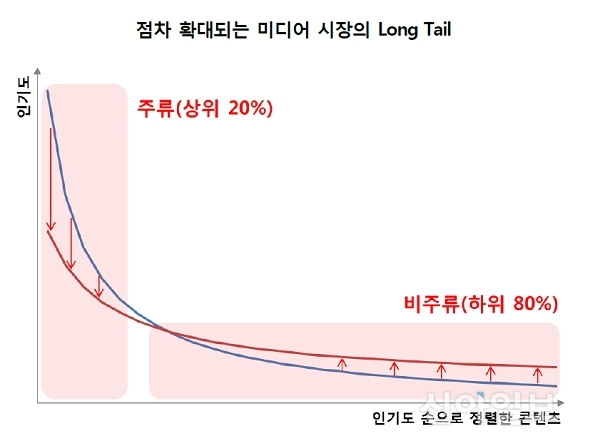  
출처 : [신아일보](http://www.shinailbo.co.kr/news/articleView.html?idxno=1077552)

롱테일 문제는 현실세계를 반영한 문제입니다.  
사람들은 인기 있는 주류의 아이템을 주료 평가하며 인기없는 비주류의 아이템은 평가하지 않습니다.

이 문제 추천시스템에도 나타나게 되는데 아이템을 추천할 때 인기있는 주류의 아이템을 추천하게 되고 계속 비슷한 유명한 아이템을 추천하여 사용자가 지루하게 느끼며 다양함에 대해 부정적인 영향을 주게 됩니다.

아마존과 같은 많은 회사는 롱테일에 위치한 비주류 아이템을 추천하여 팔면서 많은 이윤을 남겼다고 합니다.  


이러한 롱테일 문제를 개선하기 위하여 정보 검색 문헌에 쓰이는 idf(역문서빈도)의 개념을 사용하여 개선할 수 있습니다.

아이템($j$)에 대한 평점 개수를 $m_{j}$라하고, $m$은 총 사용자 수 라면  
아이템 $j$에 대한 가중치 $w_{j}$는 다음과 같습니다.

$$w_{j}=log(\frac{m}{m_{j}})$$

유사도를 계산하는 과정과 추천 과정에서 모두 각각의 아이템 $j$에 대하여 $w_{j}$가중치를 부여합니다.

$$Pearson(u,v) = \frac{∑_{k∈I_u∩I_v}w_{k}⋅(r_{uk}-μ_{u})⋅(r_{vk}-μ_{v})}{\sqrt{∑_{k∈I_u∩I_v}w_{k}⋅(r_{uk}-μ_{u})^{2}}⋅\sqrt{∑_{k∈I_{u}∩I_{v}}w_{k}⋅(r_{vk}-μ_{v})^{2}}}$$